<a href="https://colab.research.google.com/github/Emmima10/Applied-ML/blob/main/Mixed_Data_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Segmentation with Mixed Data

In [1]:
!pip install kmodes
!pip install gower

In [17]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gower
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [3]:
df = pd.read_csv("/content/superstore.csv", encoding='ISO-8859-1')

In [4]:
#Aggregating Data by Customer ID
customer_df = df.groupby('Customer ID').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Quantity': 'mean',
    'Segment': lambda x: x.mode()[0],
    'Category': lambda x: x.mode()[0],
    'Sub-Category': lambda x: x.mode()[0],
    'State': lambda x: x.mode()[0],
    'Region': lambda x: x.mode()[0]
}).reset_index()

In [5]:
numerical_features = ['Sales', 'Profit', 'Discount', 'Quantity']
categorical_features = ['Segment', 'Category', 'Sub-Category', 'State', 'Region']
all_features = numerical_features + categorical_features

In [6]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X = preprocessor.fit_transform(customer_df[all_features])

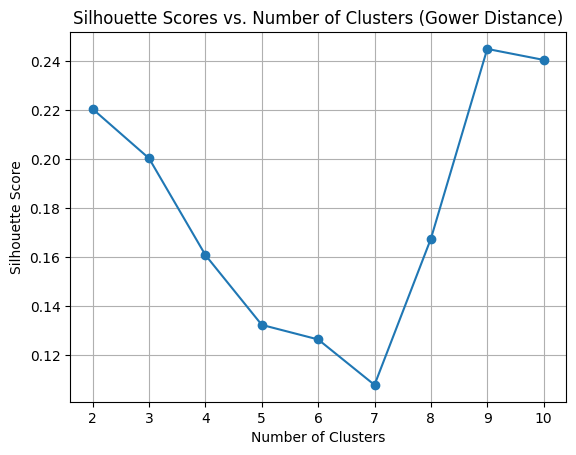

Best number of clusters based on silhouette score: 9


In [7]:
# Computing Gower distance matrix
gower_dist = gower.gower_matrix(customer_df[all_features])

sil_scores = []
k_range = range(2, 11)

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    labels = model.fit_predict(gower_dist)
    score = silhouette_score(gower_dist, labels, metric='precomputed')
    sil_scores.append(score)


plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Scores vs. Number of Clusters (Gower Distance)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

best_k = k_range[sil_scores.index(max(sil_scores))]
print(f"Best number of clusters based on silhouette score: {best_k}")

In [8]:
best_model = AgglomerativeClustering(n_clusters=9, metric='precomputed', linkage='average')
best_labels = best_model.fit_predict(gower_dist)

customer_df['Cluster_Gower'] = best_labels

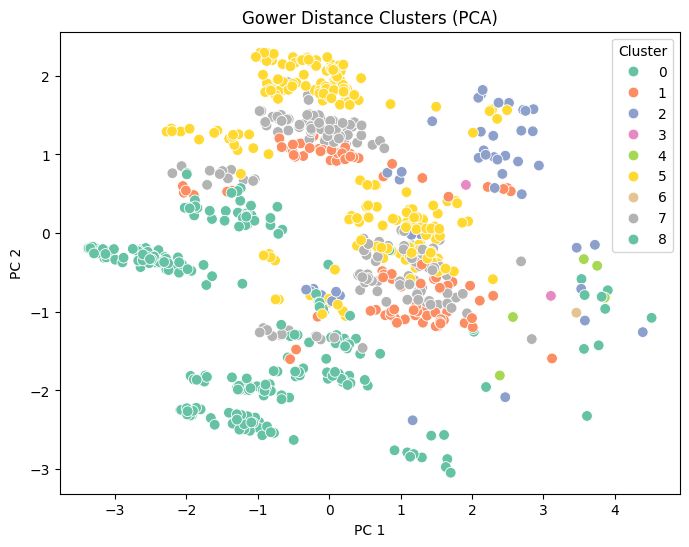

In [9]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(gower_dist)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_embedding[:, 0], y=pca_embedding[:, 1], hue=best_labels, palette='Set2', s=60)
plt.title('Gower Distance Clusters (PCA)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.show()

In [10]:
score = silhouette_score(gower_dist, best_labels, metric='precomputed')
print(f"Silhouette Score (Gower + Agglomerative): {score:.4f}")

Silhouette Score (Gower + Agglomerative): 0.2450


In [11]:
customer_kproto_df = customer_df.copy()
customer_kproto_df[categorical_features] = customer_kproto_df[categorical_features].astype(str)

data_matrix = customer_kproto_df[all_features].to_numpy()

cat_cols_pos = [all_features.index(col) for col in categorical_features]


X_encoded = preprocessor.transform(customer_df[all_features])
X_encoded_dense = X_encoded.toarray() if hasattr(X_encoded, "toarray") else X_encoded


k_range = range(2, 11)
db_scores = []

for k in k_range:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    clusters = kproto.fit_predict(data_matrix, categorical=cat_cols_pos)
    db = davies_bouldin_score(X_encoded_dense, clusters)
    db_scores.append(db)
    print(f"k={k} → Davies‑Bouldin score = {db:.4f}")





k=2 → Davies‑Bouldin score = 2.1329
k=3 → Davies‑Bouldin score = 2.6408
k=4 → Davies‑Bouldin score = 3.7900
k=5 → Davies‑Bouldin score = 4.5731
k=6 → Davies‑Bouldin score = 5.4854
k=7 → Davies‑Bouldin score = 5.5212
k=8 → Davies‑Bouldin score = 4.8376
k=9 → Davies‑Bouldin score = 4.2847
k=10 → Davies‑Bouldin score = 4.6629


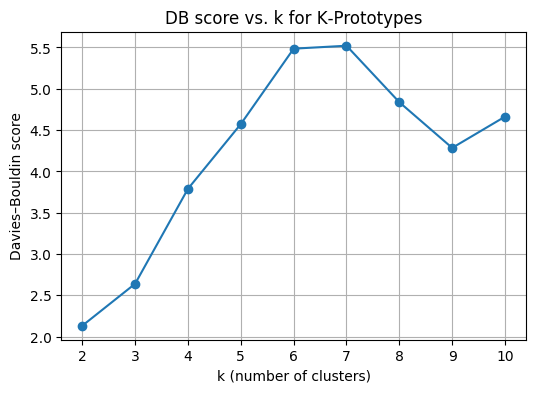

In [12]:
plt.figure(figsize=(6,4))
plt.plot(list(k_range), db_scores, marker='o')
plt.xlabel("k (number of clusters)")
plt.ylabel("Davies–Bouldin score")
plt.title("DB score vs. k for K‑Prototypes")
plt.grid(True)
plt.show()

In [13]:
best_k = k_range[np.argmin(db_scores)]
print(f"\n Optimal k = {best_k}")


 Optimal k = 2


In [14]:
kproto_final = KPrototypes(n_clusters=best_k, init='Cao', verbose=1, random_state=42)
final_clusters = kproto_final.fit_predict(data_matrix, categorical=cat_cols_pos)

customer_df['Cluster_KPrototypes'] = final_clusters

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 169, ncost: 2956912508.1870604
Run: 1, iteration: 2/100, moves: 83, ncost: 2747098135.0208373
Run: 1, iteration: 3/100, moves: 25, ncost: 2721659001.2306128
Run: 1, iteration: 4/100, moves: 10, ncost: 2713587930.0120354
Run: 1, iteration: 5/100, moves: 10, ncost: 2708930023.022147
Run: 1, iteration: 6/100, moves: 3, ncost: 2708371689.628826
Run: 1, iteration: 7/100, moves: 0, ncost: 2708371689.628826
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 39, ncost: 2731854939.6180077
Run: 2, iteration: 2/100, moves: 13, ncost: 2718961239.2499747
Run: 2, iteration: 3/100, moves: 8, ncost: 2713044585.4663463
Run: 2, iteration: 4/100, moves: 9, ncost: 2708930023.0221453
Run: 2, iteration: 5/100, moves: 3, ncost: 2708371689.6288257
Run: 2, iterati

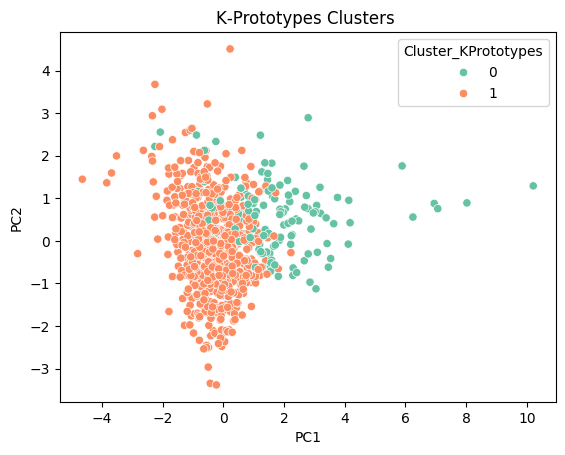

In [15]:
X_enc = preprocessor.transform(customer_df[all_features])
X_enc = X_enc.toarray() if hasattr(X_enc, "toarray") else X_enc
pca_proto = PCA(n_components=2)
proto_pca_coords = pca_proto.fit_transform(X_enc)
customer_df['Proto_PC1'] = proto_pca_coords[:, 0]
customer_df['Proto_PC2'] = proto_pca_coords[:, 1]

plt.figure()
sns.scatterplot(data=customer_df, x='Proto_PC1', y='Proto_PC2', hue='Cluster_KPrototypes',palette='Set2')
plt.title('K‑Prototypes Clusters ')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [18]:
gower_dist = gower.gower_matrix(customer_df[all_features])

X_enc = preprocessor.transform(customer_df[all_features])
X_enc_dense = X_enc.toarray() if hasattr(X_enc, "toarray") else X_enc


labels_gower = customer_df['Cluster_Gower'].values
labels_proto = customer_df['Cluster_KPrototypes'].values


sil_gower = silhouette_score(gower_dist, labels_gower, metric='precomputed')
sil_proto = silhouette_score(X_enc_dense, labels_proto)

db_gower  = davies_bouldin_score(X_enc_dense, labels_gower)
db_proto  = davies_bouldin_score(X_enc_dense, labels_proto)

ch_gower  = calinski_harabasz_score(X_enc_dense, labels_gower)
ch_proto  = calinski_harabasz_score(X_enc_dense, labels_proto)

size_gower = np.bincount(labels_gower)
size_proto = np.bincount(labels_proto)

print(f"""\
Silhouette:        Gower = {sil_gower:.3f}    Proto = {sil_proto:.3f}
Davies–Bouldin:     Gower = {db_gower:.3f}    Proto = {db_proto:.3f}
Calinski–Harabasz:  Gower = {ch_gower:.1f}    Proto = {ch_proto:.1f}

Cluster sizes:
  Gower clusters:    {size_gower}
  Proto clusters:    {size_proto}
""")

Silhouette:        Gower = 0.245    Proto = 0.184
Davies–Bouldin:     Gower = 2.609    Proto = 2.133
Calinski–Harabasz:  Gower = 18.8    Proto = 98.1

Cluster sizes:
  Gower clusters:    [ 21  97  45   2   5 221   1 172 229]
  Proto clusters:    [136 657]



In [19]:
#Cluster_KPrototypes

profile = customer_df.groupby('Cluster_KPrototypes').agg({
    'Sales': ['mean', 'sum'],
    'Profit': ['mean', 'sum'],
    'Discount': 'mean',
    'Quantity': 'mean',
    'Segment': lambda x: x.mode()[0],
    'Category': lambda x: x.mode()[0],
    'Region': lambda x: x.mode()[0]
}).reset_index()

profile.columns = ['Cluster'] + [
    f"{m}_{stat}" if stat else m
    for m, stat in profile.columns.tolist()[1:]
]

print(profile)

   Cluster   Sales_mean     Sales_sum  Profit_mean   Profit_sum  \
0        0  7370.792299  1.002428e+06  1190.353782  161888.1143   
1        1  1970.735324  1.294773e+06   189.511275  124508.9074   

   Discount_mean  Quantity_mean Segment_<lambda> Category_<lambda>  \
0       0.141567       3.931486         Consumer   Office Supplies   
1       0.160776       3.759126         Consumer   Office Supplies   

  Region_<lambda>  
0            West  
1            East  


In [20]:
#Cluster_Gower

profile = customer_df.groupby('Cluster_Gower').agg({
    'Sales': ['mean', 'sum'],
    'Profit': ['mean', 'sum'],
    'Discount': 'mean',
    'Quantity': 'mean',
    'Segment': lambda x: x.mode()[0],
    'Category': lambda x: x.mode()[0],
    'Region': lambda x: x.mode()[0]
}).reset_index()

profile.columns = ['Cluster'] + [
    f"{m}_{stat}" if stat else m
    for m, stat in profile.columns.tolist()[1:]
]

print(profile)

   Cluster    Sales_mean    Sales_sum  Profit_mean  Profit_sum  Discount_mean  \
0        0   2631.981500   55271.6115   415.524452   8726.0135       0.136690   
1        1   2930.400137  284248.8133   408.161929  39591.7071       0.171088   
2        2   2588.323211  116474.5445   199.103300   8959.6485       0.164738   
3        3    106.215000     212.4300    29.874200     59.7484       0.000000   
4        4   3276.670600   16383.3530   510.805000   2554.0250       0.108139   
5        5   2689.474484  594373.8609   295.225505  65244.8365       0.152823   
6        6  25043.050000   25043.0500 -1980.739300  -1980.7393       0.246667   
7        7   2972.471785  511265.1471   419.873886  72218.3084       0.181788   
8        8   3030.253493  693928.0500   397.482417  91023.4736       0.140502   

   Quantity_mean Segment_<lambda> Category_<lambda> Region_<lambda>  
0       3.917402        Corporate         Furniture            West  
1       3.834450         Consumer   Office Suppli